In [1]:
import os
os.chdir('..')

In [4]:
pwd

'/mnt/md1/user_victor/automatic_melody_harmonization/notebook'

In [3]:
from tonal import pianoroll2number, joint_prob2pianoroll96
from tonal import tonal_centroid, chord482note, chord962note, note2number
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pickle
from model.MusicCVAE import MusicCVAE
from decode import *
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tonal'

In [10]:
melody_framewise = np.load('./data/melody_data.npy')
chord_groundtruth_idx = np.load('./data/chord_groundtruth.npy')

melody = np.load('./data/melody_baseline.npy')
chord = np.load('./data/number_96.npy')
chord_onehot = np.load('./data/onehot_96.npy')
length = np.load('./data/length.npy')

f = open('./data/tempos', 'rb')
tempos = pickle.load(f)
f.close()
f = open('./data/downbeats', 'rb')
downbeats = pickle.load(f)
f.close()

In [11]:
val_size = 500
print('splitting testing set...')
val_melody_framewise = melody_framewise[:val_size]
val_chord_groundtruth_idx = chord_groundtruth_idx[:val_size]

val_chord = torch.from_numpy(chord_onehot[:val_size]).float()
val_melody = torch.from_numpy(melody[:val_size]).float()
val_length = torch.from_numpy(length[:val_size])



splitting testing set...


In [2]:
# Load model
device = 'cpu'
print('building model...')
model = MusicCVAE(teacher_forcing = False, eps_i=0, device = device).to(device)
model.load_state_dict(torch.load('output_models/model_music_cvae.pth',map_location='cpu'))
# print(model)
model.eval()
# val_length, val_melody = val_length.to(device), val_melody.to(device)

building model...


NameError: name 'MusicCVAE' is not defined

In [17]:
####
bs = 500
index = 8
torch.manual_seed(0)
input_melody_seqs = val_melody
length = val_length

model.batch_size = bs
model.eps_i = 0
z = torch.randn(bs,256).to(device)
melody_token = model.melody_embedding(input_melody_seqs,length)
# print('mt',melody_token.shape)
# melody_token =  torch.randn((bs,512))
_, samples = model.decode(z, melody_token, None, input_melody_seqs)
print(samples[index])
logits = torch.max(samples[index][:20],-1)
gen_chord_index = logits.indices
print(gen_chord_index)

####
bs2 = 1

model.batch_size = bs2
input_melody_seqs_ = input_melody_seqs[index].unsqueeze(0)
length_ = length[index].unsqueeze(0)

z_ = z[index].unsqueeze(0)
melody_token_ = model.melody_embedding(input_melody_seqs_,length_)
# melody_token_ = melody_token[index].unsqueeze(0)
_, sample = model.decode(z_, melody_token_, None, input_melody_seqs_)
print(sample)
logits = torch.max(sample[0][:20],-1)
gen_chord_index = logits.indices
print(gen_chord_index)

tensor([[7.8061e-01, 8.2400e-02, 2.7196e-07,  ..., 1.6833e-05, 1.1789e-05,
         1.2932e-04],
        [3.8444e-01, 3.0605e-01, 1.1131e-06,  ..., 7.1804e-05, 2.6794e-05,
         9.4035e-04],
        [1.5823e-02, 6.1488e-01, 2.5380e-04,  ..., 3.2379e-05, 1.6504e-07,
         5.3221e-06],
        ...,
        [1.7560e-01, 1.5253e-01, 1.2453e-04,  ..., 3.6389e-04, 6.6480e-05,
         7.2749e-05],
        [3.0434e-01, 1.4277e-01, 1.7128e-04,  ..., 1.7303e-04, 1.4144e-05,
         3.7537e-05],
        [1.8439e-01, 1.6375e-01, 1.9197e-04,  ..., 3.2182e-04, 5.1014e-05,
         1.9522e-04]], grad_fn=<SelectBackward>)
tensor([ 0,  0,  1,  1,  1,  1,  1,  1, 64, 64, 80, 80, 80, 80, 24, 24, 41,  3,
         1,  1])
tensor([[[6.3299e-01, 1.0944e-01, 4.9832e-06,  ..., 2.5885e-05,
          9.5352e-06, 9.5390e-05],
         [3.7281e-01, 3.1074e-01, 1.8170e-06,  ..., 6.6280e-05,
          2.0818e-05, 6.1877e-04],
         [2.3459e-02, 6.3046e-01, 1.7700e-05,  ..., 3.5878e-05,
          4.8738e-0

tensor([45])
melody_token shape torch.Size([1, 2048])
chord pred shape torch.Size([272, 96])
max logits torch.return_types.max(
values=tensor([0.6693, 0.4054, 0.5454, 0.4418, 0.6465, 0.5897, 0.6137, 0.5543, 0.4828,
        0.4988, 0.2487, 0.1944, 0.2405, 0.3051, 0.5003, 0.5920, 0.6189, 0.2741,
        0.5901, 0.5341, 0.4599, 0.3289, 0.8804, 0.6911, 0.5834, 0.5803, 0.5518,
        0.5102, 0.4037, 0.4790, 0.2629, 0.2515, 0.6533, 0.5627, 0.6228, 0.5999,
        0.6073, 0.4902, 0.4047, 0.3381, 0.5386, 0.5615, 0.3913, 0.3364, 0.4714],
       grad_fn=<MaxBackward0>),
indices=tensor([ 0,  1,  1,  1,  1,  1,  1,  1, 64, 64, 80, 80, 80, 80, 24, 24, 41,  3,
         1,  1, 56, 56,  1,  1,  1,  1,  1,  1, 64, 64, 80, 56,  1,  1, 41, 41,
         1,  1,  0,  1,  1,  1,  1,  1,  0]))


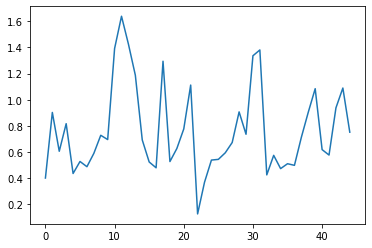

In [41]:
# Sampconductorne song
# torch.manual_seed(0)
i = 8
sample_melody = val_melody[i].unsqueeze(0)
sample_length = val_length[i].unsqueeze(0)
sample_chord = val_chord[i]
sample_melody_framewise = np.expand_dims(val_melody_framewise[i],axis=0)
sample_chord_groundtruth_idx = np.expand_dims(val_chord_groundtruth_idx[i],axis=0)
sample_tempo = [tempos[i]]
sample_downbeat = [downbeats[i]]

print(sample_length)

# bs = 1
# model.batch_size = bs
# torch.manual_seed(0)
latent_size = 256
z = z_

# for k in range(10):
melody_token = model.melody_embedding(sample_melody,sample_length)
print('melody_token shape',melody_token.shape)

output_seq, chord_pred = model.decode(z, melody_token, None, sample_melody)
print('chord pred shape',chord_pred[0].shape)

logits = torch.max(chord_pred[0][:sample_length[0]],-1)
gen_chord_index = logits.indices
print('max logits',logits)
# print('max index',gen_chord_index)


surprisingness = -np.log(torch.max(chord_pred[:,:sample_length],2).values.squeeze().detach().numpy())

fig, ax = plt.subplots()
ax.plot(surprisingness)


In [69]:
logits = top_k_top_p_filtering(distribution, top_k=3)
probs = F.softmax(logits, dim=-1)
# probs
idx = torch.multinomial(probs, 1).item()
# idx

40

In [163]:
i = 50

In [59]:
chord_note = []
tonal_distance_by_seq = [0]

for t in gen_chord_index:
    chord_label = chord962note(t)
    chord_note.append(note2number(chord962note(t)))

    print('chord_label',chord_label)


chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']
chord_label ['C', 'E', 'G']


In [42]:
########## Random sampling ###########
# Proceed chord decode

print('proceed chord decode...')
joint_prob = samples[i].unsqueeze(0).cpu().detach().numpy()

# Append argmax index to get pianoroll array
accompany_pianoroll = argmax2pianoroll(joint_prob)

# augment chord into frame base
BEAT_RESOLUTION = 24
BEAT_PER_CHORD = 2

accompany_pianoroll_framewise, sample_chord_groundtruth_framewise = sequence2frame(accompany_pianoroll, sample_chord_groundtruth_idx)

# length into frame base
sample_length_framewise = sample_length * BEAT_RESOLUTION * BEAT_PER_CHORD

# write pianoroll
result_dir = 'results/music_cvae_ar_test'
filename = str(i)
write_one_pianoroll(result_dir, filename, sample_melody_framewise, accompany_pianoroll_framewise, sample_chord_groundtruth_framewise, sample_length_framewise, sample_tempo, sample_downbeat)


proceed chord decode...
accompany_pianoroll shape (1, 272, 128)
augment chord into frame base...
accompany_pianoroll frame shape: (1, 13056, 128)
groundtruth_pianoroll frame shape: (1, 13056, 128)
write pianoroll...
Finished!


In [44]:
joint_prob.shape

(1, 272, 96)